<a href="https://colab.research.google.com/github/Kryptera-K/AAPL-Bull-Pressure-Breakout-with-RSI-DeMarker-Exhaustion-Strategy/blob/main/AAPL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import vectorbt as vbt

# -------------------------
# Download Data
# -------------------------

symbol = "AAPL"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.to_csv("AAPL_clean.csv", index=False)
df

/tmp/ipython-input-3536232561.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,0.839281,0.843498,0.762429,0.786328,535796800
2000-01-04,0.768521,0.829440,0.758680,0.811633,512377600
2000-01-05,0.779767,0.828971,0.772270,0.777893,778321600
2000-01-06,0.712287,0.802260,0.712287,0.795700,767972800
2000-01-07,0.746027,0.757274,0.716037,0.723534,460734400
...,...,...,...,...,...
2025-11-13,272.950012,276.700012,272.089996,274.109985,49602800
2025-11-14,272.410004,275.959991,269.600006,271.049988,47431300
2025-11-17,267.459991,270.489990,265.730011,268.820007,45018300


In [ ]:
# -------------------------
# Necessary Parameters
# -------------------------

BULL_EMA_PERIOD = 13
BULL_LEVEL = 0
DEM_LEVEL = 0.5
DEM_PERIOD = 14
DEM_SHIFT_1 = 5
DEM_SHIFT_2 = 10
DEM_SHIFT_3 = 15
KC_MULTIPLIER = 2
KC_PERIOD = 20
KC_SHIFT = 5
RSI_OVERBOUGHT_LEVEL = 70
RSI_OVERSOLD_LEVEL = 30
RSI_PERIOD = 14
RSI_SHIFT = 5
RSI_SHIFT_2 = 10

# -------------------------
# Indicator Functions
# -------------------------

def kc_open_above_lower_after_above(df, shift=KC_SHIFT):
    df = calculate_keltner_channel(df)
    return df['Open'].gt(df['KC_Lower']) & df['Open'].shift(shift).gt(df['KC_Lower'])


def calculate_keltner_channel(df, period=KC_PERIOD, multiplier=KC_MULTIPLIER):
    """
    Calculate Keltner Channel (Mid, Upper, Lower) and ATR.
    """
    df = df.copy()

    # Typical Price
    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3

    # EMA of Typical Price
    df['KC_Mid'] = df['TP'].ewm(span=period, adjust=False).mean()

    # True Range and ATR
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(period).mean()

    # Upper and Lower Bands
    df['KC_Upper'] = df['KC_Mid'] + multiplier * df['ATR']
    df['KC_Lower'] = df['KC_Mid'] - multiplier * df['ATR']

    return df


def bull_power_higher_than(df, EMA_PERIOD=BULL_EMA_PERIOD, level=BULL_LEVEL):
    df = calculate_bull_power(df, EMA_PERIOD)
    return df['Bull_Power'] > level


def calculate_bull_power(df, EMA_PERIOD=BULL_EMA_PERIOD):
    """
    Calculate Bull Power indicator.
    Bull Power = High - EMA(Close)
    """
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=EMA_PERIOD, adjust=False).mean()
    df['Bull_Power'] = df['High'] - df['EMA']
    return df


def rsi_lower_than_os(df, level=RSI_OVERSOLD_LEVEL):
    df = calculate_rsi(df)
    return df['RSI'] < level


def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df


def demarker_cross_below_level(df, level=DEM_LEVEL, shift_1=DEM_SHIFT_1, shift_2=DEM_SHIFT_2):
    df = calculate_demarker(df)
    return (df['DeMarker'].shift(shift_2) > level) & \
           (df['DeMarker'].shift(shift_1) < level)


def calculate_demarker(df, period=DEM_PERIOD):
    """
    Calculate DeMarker indicator.
    """
    df = df.copy()

    # DeMax and DeMin
    df['DeMax'] = np.where(df['High'] > df['High'].shift(1),
                           df['High'] - df['High'].shift(1), 0)
    df['DeMin'] = np.where(df['Low'] < df['Low'].shift(1),
                           df['Low'].shift(1) - df['Low'], 0)

    # Rolling sums
    dem_max = df['DeMax'].rolling(window=period).sum()
    dem_min = df['DeMin'].rolling(window=period).sum()

    df['DeMarker'] = dem_max / (dem_max + dem_min)
    return df



# -------------------------
# Entry conditions
# -------------------------

df["KC_Open_Above_Lower_After_Above"] = kc_open_above_lower_after_above(df)
df["BullP_Higher_0"] = bull_power_higher_than(df)

# -------------------------
# Exit conditions
# -------------------------

df["RSI_Lower_Than_OS"] = rsi_lower_than_os(df)
df["Demarker_Cross_Below_Level"] = demarker_cross_below_level(df)

# -------------------------
# Signals
# -------------------------

entry_conditions = [
    'KC_Open_Above_Lower_After_Above',
    'BullP_Higher_0',
]
exit_conditions = [
    'RSI_Lower_Than_OS',
    'Demarker_Cross_Below_Level',
]

df['entry_signal'] = df[entry_conditions].all(axis=1)
df['exit_signal']  = df[exit_conditions].all(axis=1)

# -------------------------
# Backtest
# -------------------------


shift_entries = df['entry_signal'].shift(1).astype(bool).fillna(False).to_numpy()
shift_exits = df['exit_signal'].shift(1).astype(bool).fillna(False).to_numpy()

pf = vbt.Portfolio.from_signals(
    close=df['Open'],
    entries=shift_entries,
    exits=shift_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='1d'
)


# -------------------------
# Portfolio Stats / Plot
# -------------------------

print(pf.stats())
pf.plot().show()

Start                                 2000-01-03 00:00:00
End                                   2025-11-19 00:00:00
Period                                 6511 days 00:00:00
Start Value                                      100000.0
End Value                                 51174135.789239
Total Return [%]                             51074.135789
Benchmark Return [%]                         33667.723478
Max Gross Exposure [%]                              100.0
Total Fees Paid                            1534001.854884
Max Drawdown [%]                                 54.28067
Max Drawdown Duration                   741 days 00:00:00
Total Trades                                           51
Total Closed Trades                                    50
Total Open Trades                                       1
Open Trade PnL                            12715550.628285
Win Rate [%]                                         62.0
Best Trade [%]                                 314.104035
Worst Trade [%

In [ ]:
# Buy and Hold Performance Metrics
df_holding = df['Open']
pf_holding = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf_holding.stats())

Start                         2000-01-03 00:00:00
End                           2025-11-19 00:00:00
Period                         6511 days 00:00:00
Start Value                              100000.0
End Value                         33767723.478346
Total Return [%]                     33667.723478
Benchmark Return [%]                 33667.723478
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        81.760433
Max Drawdown Duration          1206 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                    33667723.478346
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN


/tmp/ipython-input-2472533964.py:15: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


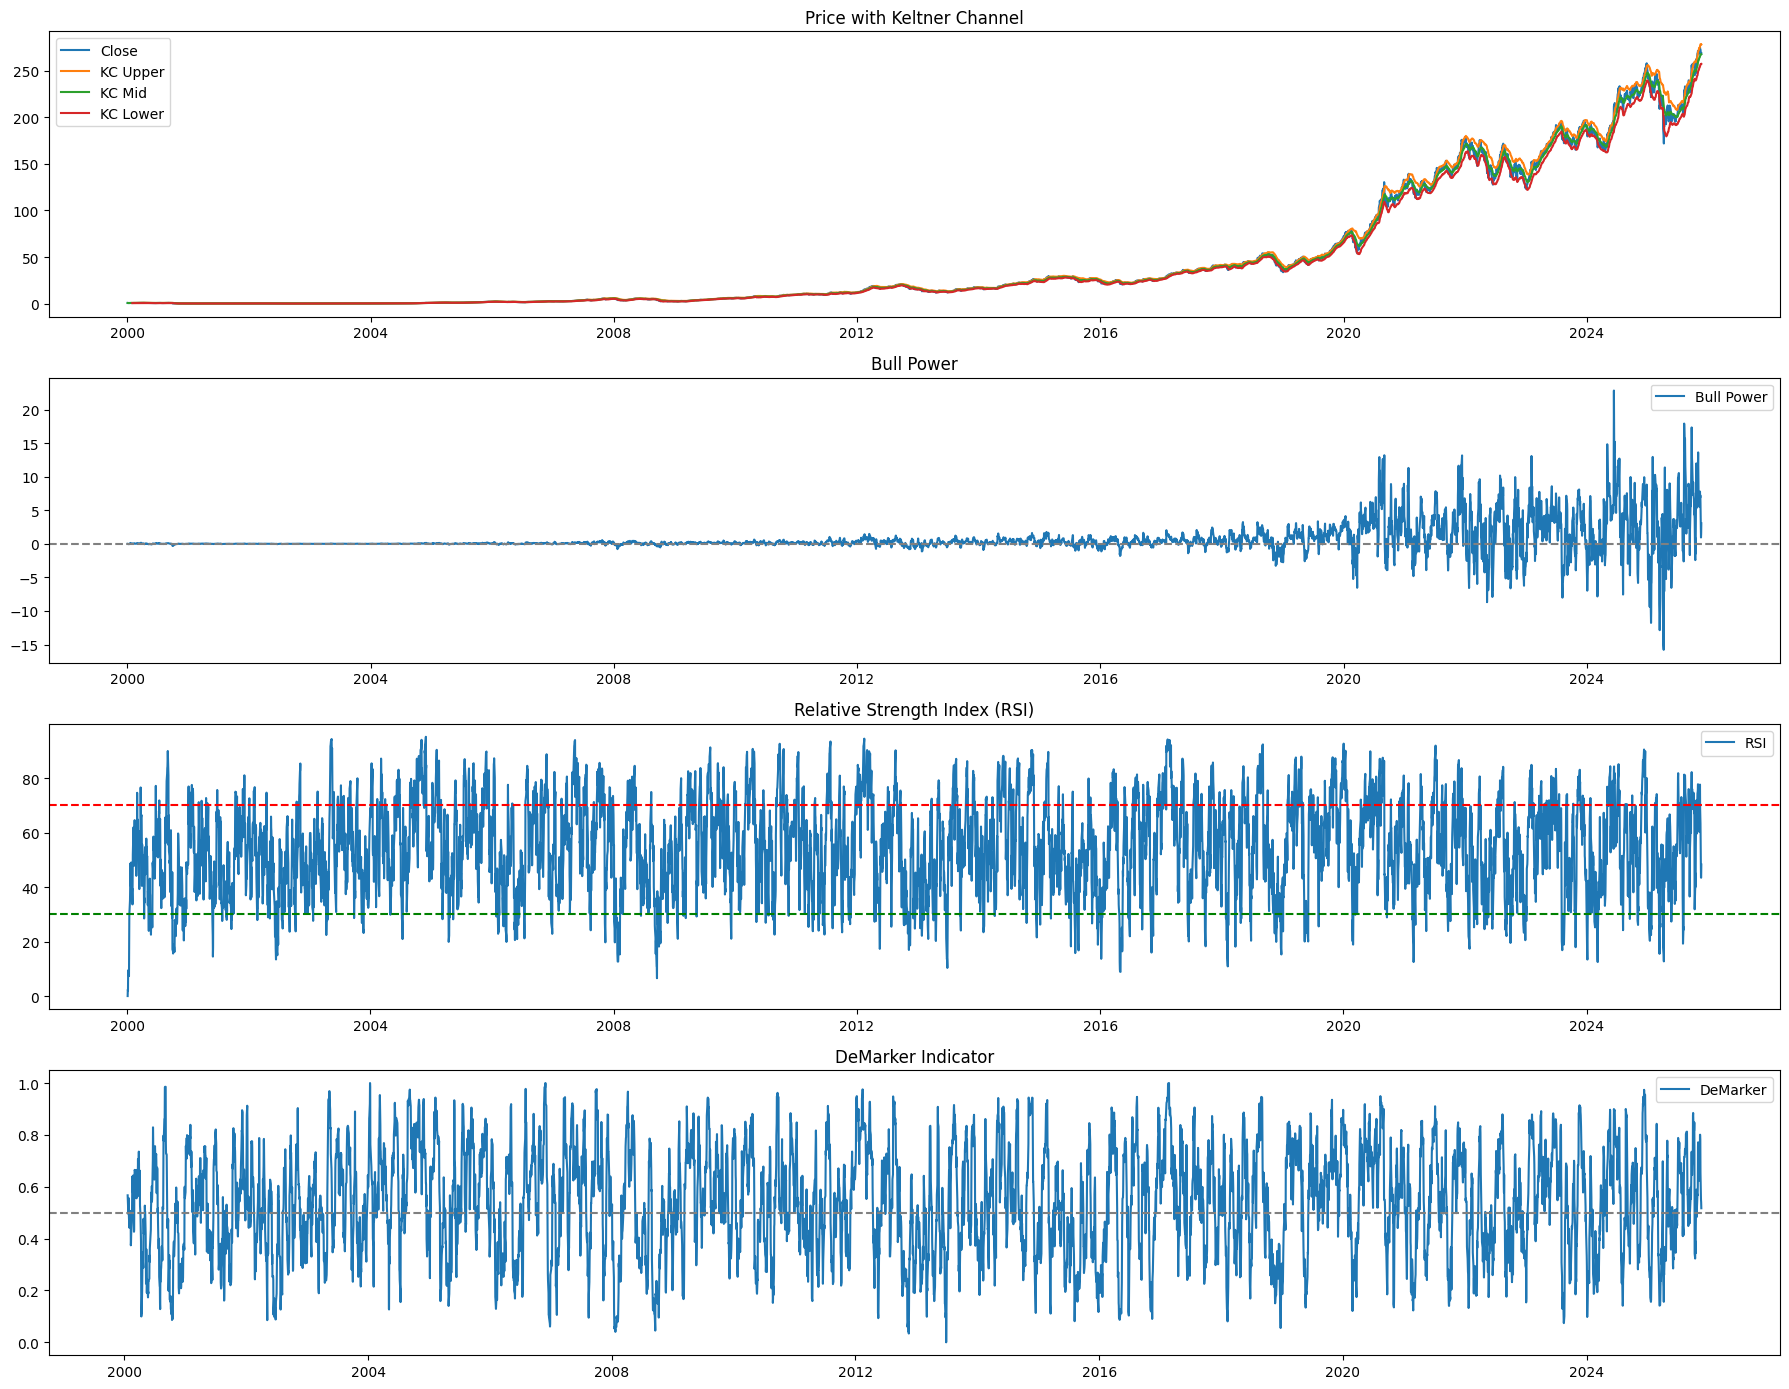

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# -------------------------
# Download Data
# -------------------------

symbol = "AAPL"
start_date = "2000-01-01"
end_date = "2026-01-01"
interval = "1d"

df = yf.download(symbol, start=start_date, end=end_date, interval=interval, multi_level_index=False)
df.dropna(inplace=True)

# -------------------------
# Parameters
# -------------------------

BULL_EMA_PERIOD = 13
DEM_PERIOD = 14
KC_PERIOD = 20
KC_MULTIPLIER = 2
RSI_PERIOD = 14


# -------------------------
# Indicator Functions
# -------------------------

def calculate_keltner_channel(df, period=KC_PERIOD, multiplier=KC_MULTIPLIER):
    df = df.copy()

    df['TP'] = (df['High'] + df['Low'] + df['Close']) / 3
    df['KC_Mid'] = df['TP'].ewm(span=period, adjust=False).mean()

    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L','H-PC','L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(period).mean()

    df['KC_Upper'] = df['KC_Mid'] + multiplier * df['ATR']
    df['KC_Lower'] = df['KC_Mid'] - multiplier * df['ATR']

    return df


def calculate_bull_power(df, EMA_PERIOD=BULL_EMA_PERIOD):
    df = df.copy()
    df['EMA'] = df['Close'].ewm(span=EMA_PERIOD, adjust=False).mean()
    df['Bull_Power'] = df['High'] - df['EMA']
    return df


def calculate_rsi(df, period=RSI_PERIOD):
    delta = df['Close'].diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(span=period, adjust=False).mean()
    roll_down = down.ewm(span=period, adjust=False).mean()
    rs = roll_up / roll_down
    df['RSI'] = 100 - (100 / (1 + rs))
    return df


def calculate_demarker(df, period=DEM_PERIOD):
    df = df.copy()

    df['DeMax'] = np.where(df['High'] > df['High'].shift(1),
                           df['High'] - df['High'].shift(1), 0)
    df['DeMin'] = np.where(df['Low'] < df['Low'].shift(1),
                           df['Low'].shift(1) - df['Low'], 0)

    dem_max = df['DeMax'].rolling(period).sum()
    dem_min = df['DeMin'].rolling(period).sum()

    df['DeMarker'] = dem_max / (dem_max + dem_min)
    return df


# -------------------------
# Compute All Indicators
# -------------------------

df = calculate_keltner_channel(df)
df = calculate_bull_power(df)
df = calculate_rsi(df)
df = calculate_demarker(df)


# -------------------------
# Plot All Indicators
# -------------------------

plt.figure(figsize=(18, 14))

# --- 1. Price + Keltner Channel
plt.subplot(4, 1, 1)
plt.plot(df['Close'], label='Close')
plt.plot(df['KC_Upper'], label='KC Upper')
plt.plot(df['KC_Mid'], label='KC Mid')
plt.plot(df['KC_Lower'], label='KC Lower')
plt.title("Price with Keltner Channel")
plt.legend()

# --- 2. Bull Power
plt.subplot(4, 1, 2)
plt.plot(df['Bull_Power'], label='Bull Power')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Bull Power")
plt.legend()

# --- 3. RSI
plt.subplot(4, 1, 3)
plt.plot(df['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title("Relative Strength Index (RSI)")
plt.legend()

# --- 4. DeMarker
plt.subplot(4, 1, 4)
plt.plot(df['DeMarker'], label='DeMarker')
plt.axhline(0.5, color='gray', linestyle='--')
plt.title("DeMarker Indicator")
plt.legend()

plt.tight_layout()
plt.show()
